In [1]:
import pandas as pd
import numpy as np

raw = pd.read_csv("basic_strategies/data/aiif_eikon_eod_data.csv", index_col=0, parse_dates=True)

In [2]:
symbol = "GLD"

data = pd.DataFrame(raw[symbol])
data.rename(columns={symbol: "price"}, inplace=True)

data['return'] = np.log(data['price'] / data['price'].shift(1))

data.dropna(inplace=True)

data

,price,return
Date,,
2010-01-05,109.70,-0.000911
2010-01-06,111.51,0.016365
2010-01-07,110.82,-0.006207
2010-01-08,111.37,0.004951
2010-01-11,112.85,0.013202
...,...,...
2019-12-23,139.95,0.003077
2019-12-24,141.27,0.009388
2019-12-27,142.33,-0.000351


In [3]:
lags = 7 # originally 3

cols = []

for i in range(1, lags + 1):
    col = f"lag_{i}"
    cols.append(col)
    data[col] = data['return'].shift(i)
data.dropna(inplace=True)

In [4]:
from sklearn.metrics import accuracy_score
from sklearn import linear_model

In [5]:
lm = linear_model.LogisticRegression(C=1e7, solver="lbfgs", multi_class="auto", max_iter=1000)
# initializing the model, C values gives less weight to the regularization term

# train to predict the sign of the return
lm.fit(data[cols], np.sign(data['return']))

/opt/conda/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=10000000.0, max_iter=1000, multi_class='auto')

In [6]:
# predicting the sign of the return (same as the training set)
data['prediction'] = lm.predict(data[cols])

# number of long/short positions
data['prediction'].value_counts()

prediction
 1.0    1714
-1.0     704
Name: count, dtype: int64

In [7]:
# calculates the nuber of correct predictions
hits = np.sign(data['return'].iloc[lags:] * data['prediction'].iloc[lags:]).value_counts()
hits

 1.0    1295
-1.0    1105
 0.0      11
Name: count, dtype: int64

In [8]:
accuracy_score(data['prediction'], np.sign(data['return']))

0.5372208436724566

In [9]:
data['strategy'] = data['prediction'] * data['return']

In [10]:
results = data[['return', 'strategy']].cumsum().apply(np.exp)
results

,return,strategy
Date,,
2010-01-14,1.004393,0.995626
2010-01-15,0.993904,1.006134
2010-01-20,0.970910,0.982857
2010-01-21,0.956917,0.968693
2010-01-22,0.955135,0.970500
...,...,...
2019-12-23,1.104712,3.131383
2019-12-24,1.115132,3.160918
2019-12-27,1.114740,3.162029


<Axes: xlabel='Date'>

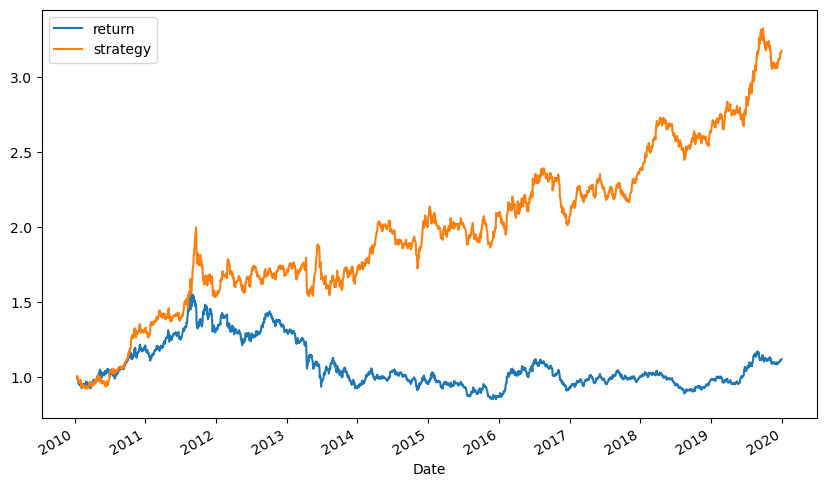

In [11]:
results.plot(figsize=(10, 6))

despite only being accurate 52% of the time or so we have pretty good looking results here. changing the lags to 7 (up from 3) gives us even better returns (before transaction fees and whatnot)

In [20]:
from basic_strategies.log_regression_backtester import ScikitVectorBacktester as SCI

/opt/conda/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/notebooks/basic_strategies/log_regression_backtester.py:110: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this k

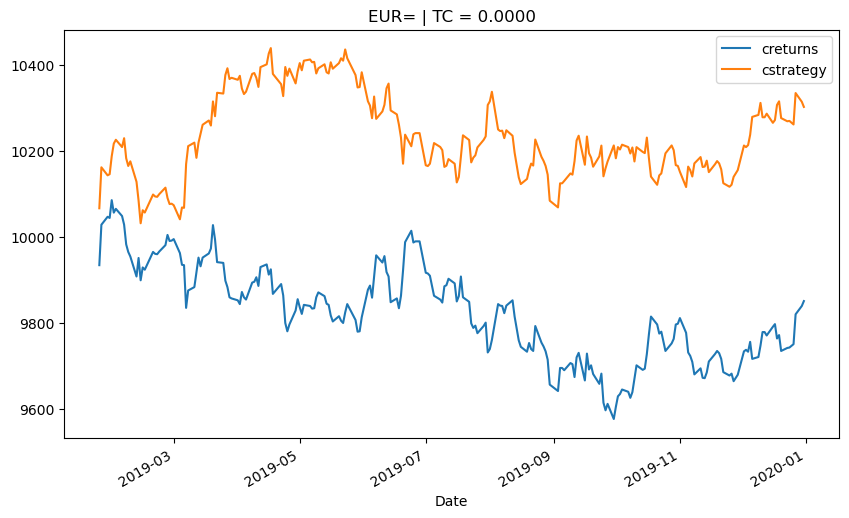

In [25]:
scibt = SCI('EUR=', '2010-1-1', '2019-12-31', 10000, 0.0, 'logistic')

# scibt.run_strategy('2015-1-1', '2019-12-31', '2015-1-1', '2019-12-31', lags=15)

scibt.run_strategy('2016-1-1', '2018-12-31','2019-1-1', '2019-12-31', lags=15)

scibt.plot_results()

/opt/conda/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/notebooks/basic_strategies/log_regression_backtester.py:110: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this k

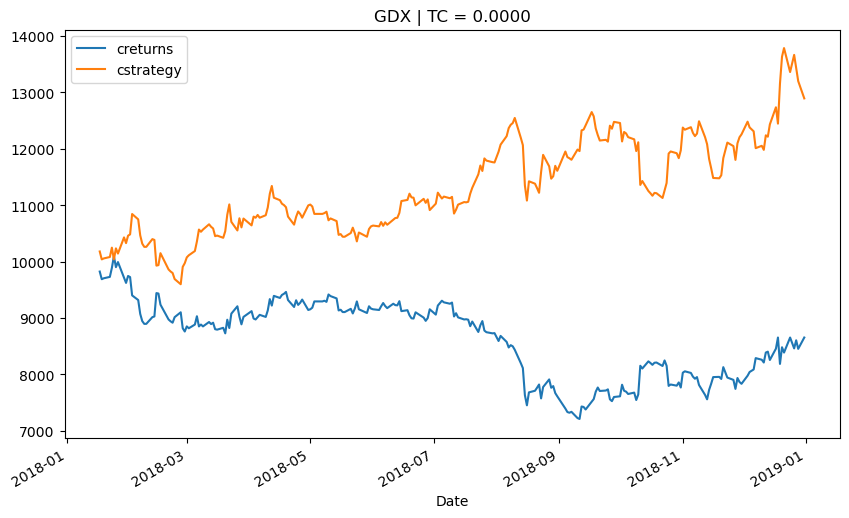

In [28]:
scibt = SCI('GDX', '2010-1-1', '2019-12-31', 10000, 0.00, 'logistic')

scibt.run_strategy('2013-1-1', '2017-12-31', '2018-1-1', '2018-12-31', lags=10)

scibt.plot_results()

the following adds in transaction costs

/opt/conda/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/notebooks/basic_strategies/log_regression_backtester.py:110: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this k

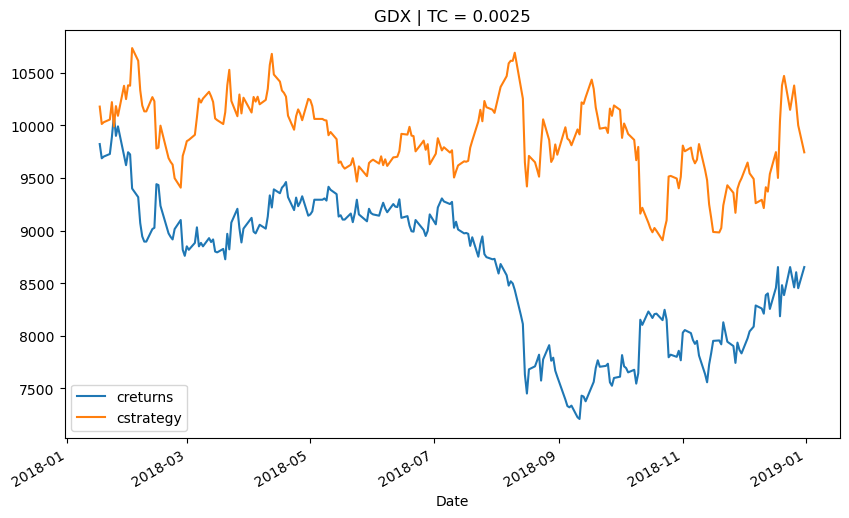

In [30]:
scibt = SCI('GDX', '2010-1-1', '2019-12-31', 10000, 0.0025, 'logistic')

scibt.run_strategy('2013-1-1', '2017-12-31', '2018-1-1', '2018-12-31', lags=10)

scibt.plot_results()

while we outperformed holding we still had a net loss with this technique...